# Programming Assigment 2
Egor Fadeev, 12313685 - Thomas Geier, 12026958

Implement a SVM (in the primal; hinge-loss + regularizer) and use SGD/Adagrad for
optimization. You will consider the following two models/features: 
1. A linear SVM using the original features of the data; and 
2. a SVM using RFFs for approximating a Gaussian kernel.  

Both models will be trained using a standard variant of SGD or
Adagrad.

In [6]:
# Import needed libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
from utils import *
from model import *
from optimizers import *
from RFF import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load and preprocess data
X_tiny, y_tiny = get_data('tiny')
X_large, y_large = get_data('large')
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = get_data('imdb')

scaler = StandardScaler()
X_tiny_scaled = scaler.fit_transform(X_tiny)
X_large_scaled = scaler.fit_transform(X_large)
X_train_imdb_scaled = scaler.fit_transform(X_train_imdb)
X_test_imdb_scaled = scaler.transform(X_test_imdb)

### Linear SVM Model 
As a baseline model implement a linear SVM and train it in a standard way (i.e., use standard mini-batch SGD). Train a SVM for each of the datasets, select a suitable learning rate and regularization parameter.

In [18]:
# Parameters to test
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.01, 0.05, 0.1]
n_epochs = 30
batch_size = 10

optimizer = MiniBatchSGD()
model = LinearSVM()

#### toydata_tiny.csv
Firt we are going to train a SVM for the *toydata_tiny.csv* data:

In [19]:
# Perform cross-validation
best_params, best_accuracy, all_results = grid_search_svm(X_tiny_scaled, y_tiny, model=LinearSVM(), optimizer=MiniBatchSGD(), 
            lambdas=lambdas, learning_rates=learning_rates, n_epochs=n_epochs, batch_size=batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 547.06it/s, loss=0.179]

Best Learning Rate: 0.001, Best Lambda: 0.01
Best Accuracy: 0.9949999999999999


In [25]:
optimizer = MiniBatchSGD(learning_rate=best_params[0])
model = LinearSVM(lambda_=best_params[1])

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 618.86it/s, loss=0.0512]


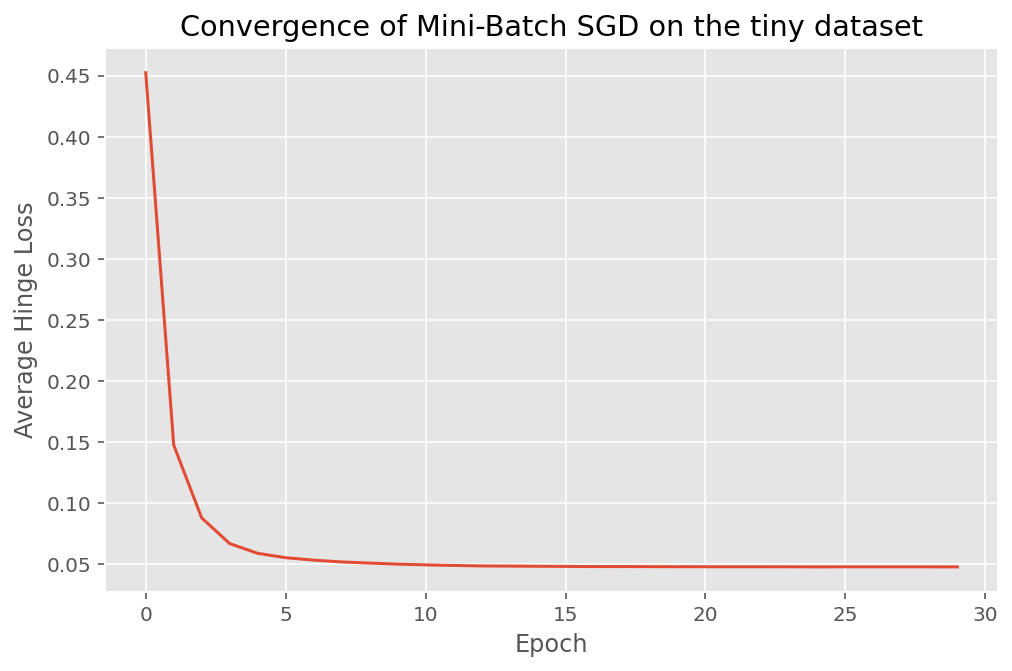

Average 5-fold cross-validation accuracy on the tiny dataset: 0.99
Average runtime on the tiny dataset: 0.09


In [26]:
average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_tiny_scaled, y_tiny, model, optimizer, n_epochs, batch_size)

# Plotting average convergence across folds
average_loss_history = np.mean(all_loss_histories, axis=0)
plt.plot(average_loss_history)
plt.title('Convergence of Mini-Batch SGD on the tiny dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Average 5-fold cross-validation accuracy on the tiny dataset: {average_accuracy:.2f}")
print(f"Average runtime on the tiny dataset: {average_runtime:.2f}")

#### toydata_large.csv
Now lets do the same for *toydata_large.csv*:

In [27]:
# Perform cross-validation
best_params, best_accuracy, all_results = grid_search_svm(X_large_scaled, y_large, model=LinearSVM(), optimizer=MiniBatchSGD(), 
            lambdas=lambdas, learning_rates=learning_rates, n_epochs=n_epochs, batch_size=batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s, loss=0.028] 

Best Learning Rate: 0.001, Best Lambda: 0.01
Best Accuracy: 1.0


In [28]:
optimizer = MiniBatchSGD(learning_rate=best_params[0])
model = LinearSVM(lambda_=best_params[1])

Training Progress: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, loss=0.00421]


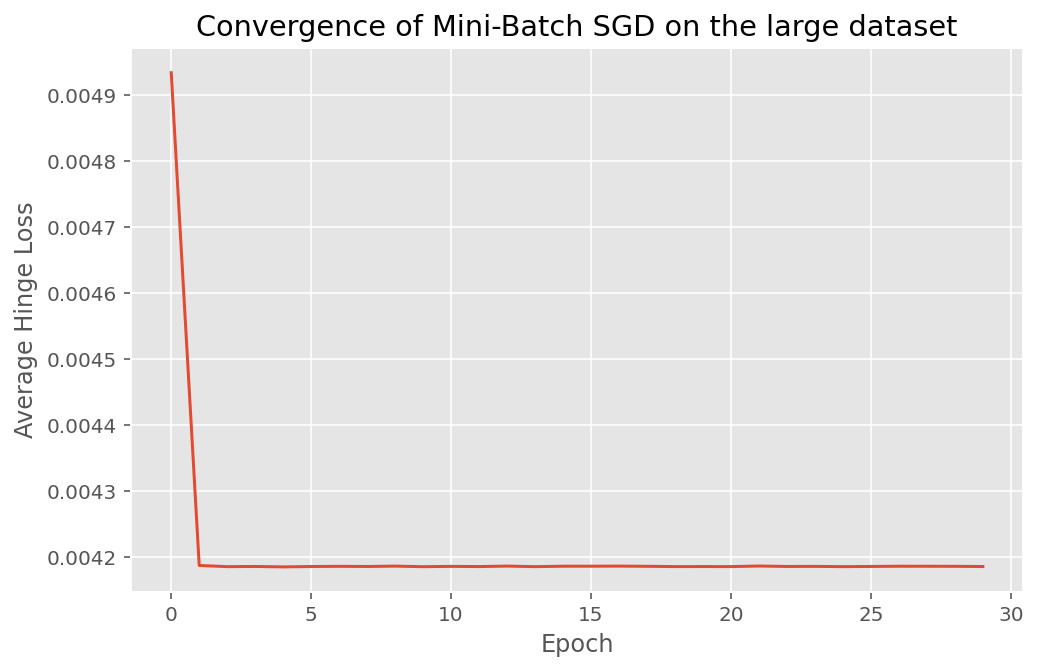

Average 5-fold cross-validation accuracy on the large dataset: 1.00
Average runtime on the large dataset: 24.57


In [30]:
average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_large_scaled, y_large, model, optimizer, n_epochs, batch_size)

# Plotting average convergence across folds
average_loss_history = np.mean(all_loss_histories, axis=0)
plt.plot(average_loss_history)
plt.title('Convergence of Mini-Batch SGD on the large dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Average 5-fold cross-validation accuracy on the large dataset: {average_accuracy:.2f}")
print(f"Average runtime on the large dataset: {average_runtime:.2f}")

#### imdb.npz
Finally we are going to train the model for *imdb.npz*:

In [3]:
# Get validation dataset
np.random.seed(420)
val_indices = np.random.choice(X_train_imdb_scaled.shape[0], size=5000, replace=False)

X_val_imdb = X_train_imdb_scaled[val_indices]
X_train_imdb = np.delete(X_train_imdb_scaled, val_indices, axis=0)
y_val_imdb = y_train_imdb[val_indices]
y_train_imdb = np.delete(y_train_imdb, val_indices, axis=0)

In [4]:
# Parameters to test
learning_rates = [0.001, 0.01]
lambdas = [0.01, 0.1]
n_epochs = 30
batch_size = 10

best_accuracy = 0
best_params = None

for lr in learning_rates:
    for lambda_ in lambdas:
        model = LinearSVM(lambda_=lambda_)
        optimizer = MiniBatchSGD(learning_rate=lr)

        model.fit(X_train_imdb, y_train_imdb, optimizer, n_epochs, batch_size)
        y_pred = model.predict(X_val_imdb)
        accuracy = accuracy_score(y_val_imdb, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (lr, lambda_)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [35:02<00:00, 70.07s/it, loss=[9.34598365]]


Best Learning Rate: 0.001, Best Lambda: 0.01
Best Accuracy: 0.8504


Training Progress: 100%|██████████| 30/30 [41:23<00:00, 82.79s/it, loss=[0.69774063]]


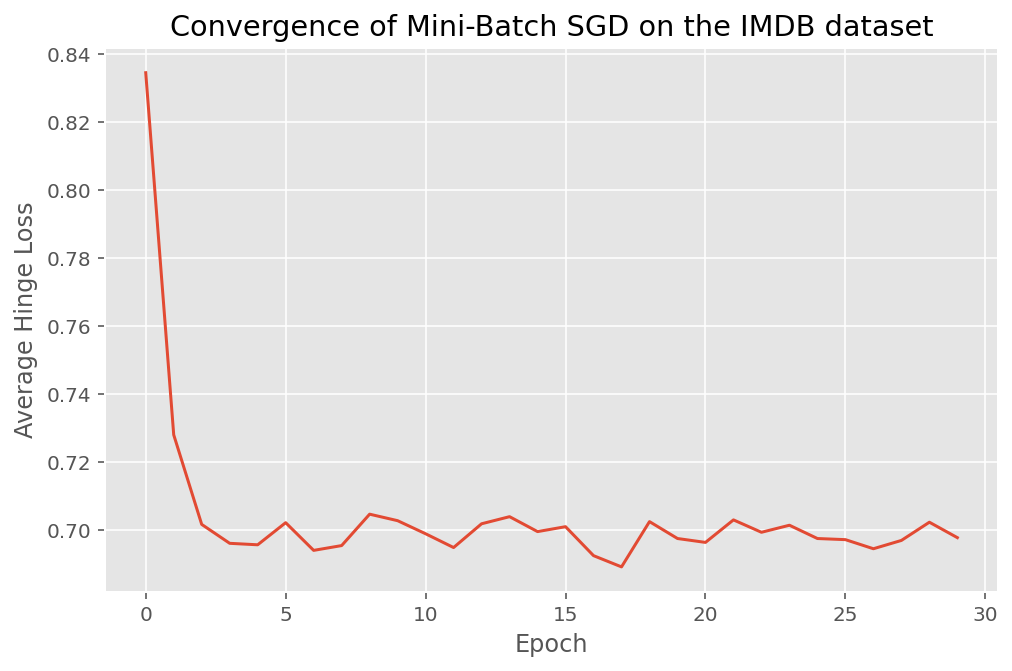

Accuracy on the IMDB dataset: 0.86
Runtime on the IMDB dataset: 2483.92


In [11]:
# Fit the model with the best hyperparameters
model = LinearSVM(lambda_=best_params[1])
optimizer = MiniBatchSGD(learning_rate=best_params[0])

X_train_val_imdb = np.vstack((X_train_imdb, X_val_imdb))
y_train_val_imdb = np.vstack((y_train_imdb, y_val_imdb))

start_time = time.time()
loss = model.fit(X_train_val_imdb, y_train_val_imdb, optimizer, n_epochs=30, batch_size=10)
runtime = time.time() - start_time

test_pred = model.predict(X_test_imdb_scaled)
accuracy = accuracy_score(y_test_imdb, test_pred)

# Plotting convergence
plt.plot(loss)
plt.title('Convergence of Mini-Batch SGD on the IMDB dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Accuracy on the IMDB dataset: {accuracy:.2f}")
print(f"Runtime on the IMDB dataset: {runtime:.2f}")

In [ ]:
# End of the 1st task

In [11]:
y_pred = model.predict(X_test_scaled)

In [12]:
accuracy_score(y_test, y_pred)

0.8602

In [ ]:
######## ------------------------Delete?-----------------------------------

# Parameters to test
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.01, 0.05, 0.1]
epochs = 30
batch_size = 10

# Perform cross-validation
best_params, best_accuracy, all_results = cross_validate_svm(X_scaled, y, lambdas, learning_rates, epochs, batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

### Optimization using Adagrad
Implement Adagrad using the diagonal
approximation for optimization. Train a linear SVMs using the original features (i.e.,
do not use the RFFs).

#### toydata_tiny.csv
Again we are starting with the *toydata_tiny.csv* set:

In [5]:
# Load and preprocess data
data = pd.read_csv('toydata_tiny.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimizer = Adagrad()
model = LinearSVM()

model.fit(X_scaled, y, optimizer, epochs=30, batch_size=10)

Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [90]:
# Load and preprocess data
data = pd.read_csv('toydata_tiny.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters to test
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.01, 0.05, 0.1]
epochs = 30
batch_size = 10

optimizer = Adagrad()
model = LinearSVM()

# Perform cross-validation
best_params, best_accuracy, all_results = cross_validate_svm(X_scaled, y, model, optimizer, lambdas, learning_rates, epochs, batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)
yi ()
xi (2,)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Random Fourier Features
Use RFFs to approximate a Gaussian kernel in
a SVM. Train SVMs with RFFs on each of the datasets, selecting a suitable learning
rate and regularization parameter. Test at least 3 different numbers of RFFs (≥ 100
features).

In [59]:
class RandomFourierFeatures:

    def __init__(self, n_components=100, gamma=1.0):
        self.n_components = n_components
        self.gamma = gamma
        self.weights = None 
        self.bias = None

    def fit(self, X):
        d = X.shape[1]
        self.weights = np.random.normal(0, np.sqrt(2 * self.gamma), size=(d, self.n_components))
        self.bias = np.random.uniform(0, 2 * np.pi, size=self.n_components)

    def transform(self, X):
        projection = np.dot(X, self.weights) + self.bias
        return np.cos(projection) * np.sqrt(2. / self.n_components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

#### toydata_tiny.csv

In [60]:
# Load and preprocess data
data = pd.read_csv('toydata_tiny.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [61]:
# Generate Random Fourier Features
rff = RandomFourierFeatures(n_components=300, gamma=0.1)
X_scaled_rff = rff.fit_transform(X_scaled)

In [62]:
# Parameters to test
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.01, 0.05, 0.1]
epochs = 30
batch_size = 10

optimizer = MiniBatchSGD()
model = LinearSVM()

# Perform cross-validation
best_params, best_accuracy, all_results = cross_validate_svm(X_scaled_rff, y, model, optimizer, lambdas, learning_rates, epochs, batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 410.28it/s, loss=0.389]

Best Learning Rate: 0.01, Best Lambda: 0.01
Best Accuracy: 0.9949999999999999


Training Progress: 100%|██████████| 30/30 [00:00<00:00, 345.24it/s, loss=0.376]


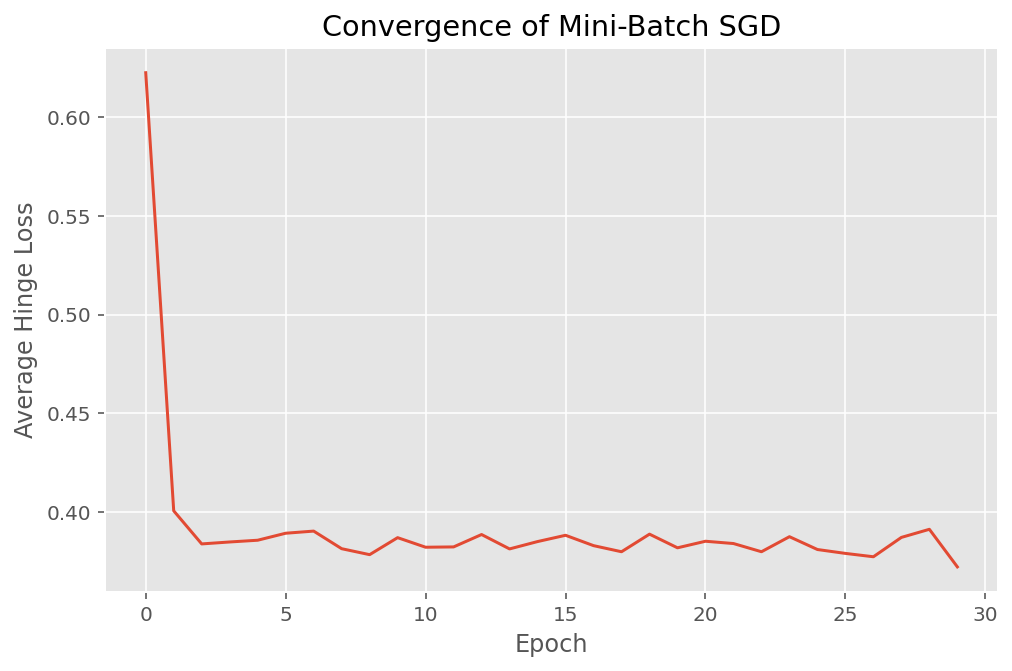

Average 5-fold cross-validation accuracy: 0.93


In [63]:
average_accuracy, all_loss_histories = cross_val_score(X_scaled_rff, y, model, optimizer, epochs, batch_size)

# Plotting average convergence across folds
average_loss_history = np.mean(all_loss_histories, axis=0)
plt.plot(average_loss_history)
plt.title('Convergence of Mini-Batch SGD')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Average 5-fold cross-validation accuracy: {average_accuracy:.2f}")

#### toydata_large.csv

In [45]:
# Load and preprocess data
data = pd.read_csv('toydata_large.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [46]:
# Generate Random Fourier Features
rff = RandomFourierFeatures(n_components=100, gamma=0.1)
X_scaled_rff = rff.fit_transform(X_scaled)

In [47]:
# Parameters to test
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.01, 0.05, 0.1]
epochs = 30
batch_size = 10

optimizer = MiniBatchSGD()
model = LinearSVM()

# Perform cross-validation
best_params, best_accuracy, all_results = cross_validate_svm(X_scaled_rff, y, model, optimizer, lambdas, learning_rates, epochs, batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [00:29<00:00,  1.03it/s, loss=0.028] 

Best Learning Rate: 0.001, Best Lambda: 0.01
Best Accuracy: 1.0


Training Progress: 100%|██████████| 30/30 [00:28<00:00,  1.04it/s, loss=0.0281]


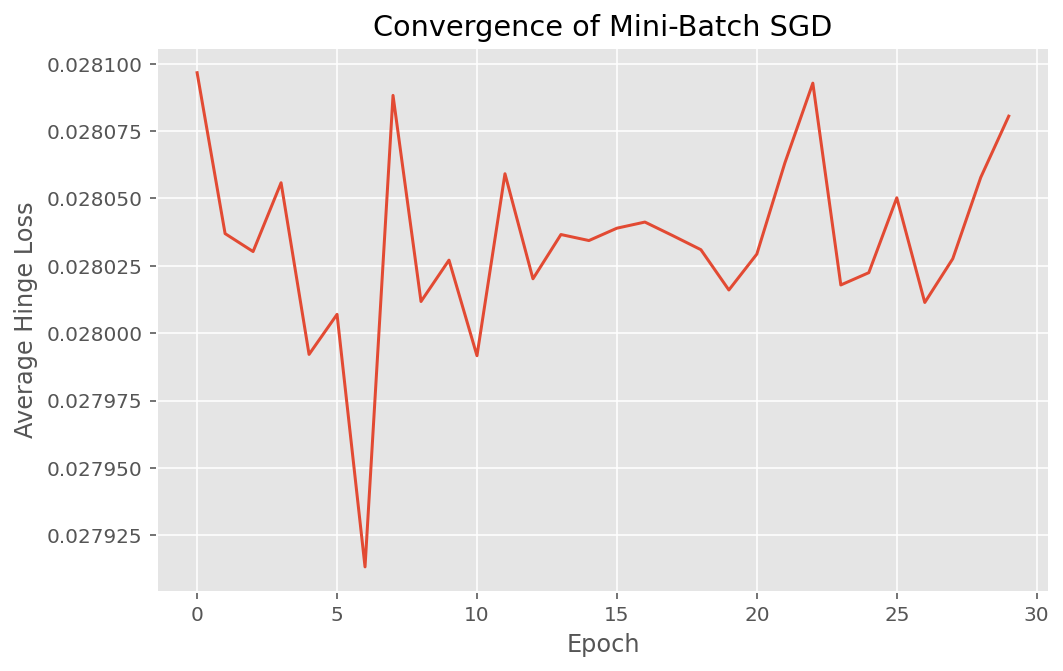

Average 5-fold cross-validation accuracy: 1.00


In [48]:
average_accuracy, all_loss_histories = cross_val_score(X_scaled_rff, y, model, optimizer, epochs, batch_size)

# Plotting average convergence across folds
average_loss_history = np.mean(all_loss_histories, axis=0)
plt.plot(average_loss_history)
plt.title('Convergence of Mini-Batch SGD')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Average 5-fold cross-validation accuracy: {average_accuracy:.2f}")

#### imdb.npz

In [83]:
data = np.load('imdb.npz', allow_pickle=True)

X_train = data['train']
y_train = data['train_labels']
X_test = data['test']
y_test = data ['test_labels']

X_train = X_train.item().todense()
X_test = X_test.item().todense()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = np.where(y_train == 0, -1, 1)
y_test = np.where(y_test == 0, -1, 1)

model = LinearSVM(lambda_=0.01)
optimizer = MiniBatchSGD(learning_rate=0.001)

In [84]:
rff = RandomFourierFeatures(n_components=10000, gamma=0.1)
X_train_scaled_rff = rff.fit_transform(X_train_scaled)
X_test_scaled_rff = rff.transform(X_test_scaled)

In [85]:
loss_history = model.fit(X_train_scaled_rff, y_train, optimizer, epochs=30)

Training Progress: 100%|██████████| 30/30 [42:18<00:00, 84.62s/it, loss=0.998]


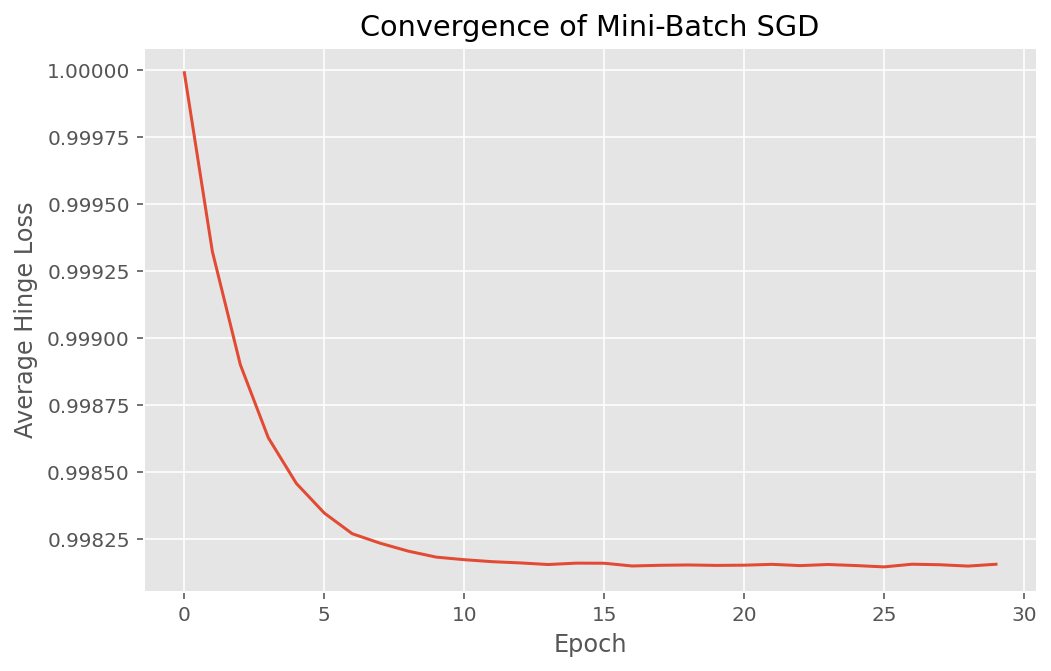

In [86]:
plt.plot(loss_history)
plt.title('Convergence of Mini-Batch SGD')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

In [87]:
y_pred = model.predict(X_test_scaled_rff)
print(accuracy_score(y_test, y_pred))

0.5174
